## Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import shapely
from shapely.geometry import Point
from shapely.geometry import Polygon
import geopandas as gpd
import geog
import os

from folium.plugins import HeatMap
import folium

## Spatial Filtering

In [2]:
dataframe = pd.read_csv('./DOB_Permit_Issuance.csv')

/Users/jlrulff/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,8,9,10,15,25,31,33,34,35,36,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dataframe = dataframe[['Expiration Date', 'Job Start Date', 'LATITUDE', 'LONGITUDE', 'Job Type','BOROUGH', 'Block', 'Lot']]
dataframe.dropna(inplace=True)

In [4]:
dataframe.head()

,Expiration Date,Job Start Date,LATITUDE,LONGITUDE,Job Type,BOROUGH,Block,Lot
0,02/15/2020 12:00:00 AM,10/10/2018 12:00:00 AM,40.820932,-73.948955,A2,MANHATTAN,1957,200
1,05/21/2019 12:00:00 AM,03/18/2019 12:00:00 AM,40.768696,-73.958425,A2,MANHATTAN,1446,151
2,01/05/2020 12:00:00 AM,03/18/2019 12:00:00 AM,40.778520,-73.960535,A2,MANHATTAN,1494,15
3,03/14/2020 12:00:00 AM,05/31/2013 12:00:00 AM,40.705521,-73.922715,A1,BROOKLYN,3199,26
4,07/03/2019 12:00:00 AM,03/18/2019 12:00:00 AM,40.771173,-73.955947,A2,MANHATTAN,1451,9


In [5]:
dataframe['Job Start Date'] = pd.to_datetime(dataframe['Job Start Date'], errors='coerce', format='%m/%d/%Y %H:%M:%S %p')
dataframe['Expiration Date'] = pd.to_datetime(dataframe['Expiration Date'], errors='coerce', format='%m/%d/%Y %H:%M:%S %p')

In [6]:
# dataframe = dataframe[dataframe['Expiration Date'] > '2016-04-01']
dataframe = dataframe[dataframe['Job Start Date'] < '2017-04-01']
dataframe = dataframe[dataframe['Job Start Date'] > '2016-04-01']

dataframe = dataframe[dataframe['Expiration Date'] > dataframe['Job Start Date']]

In [7]:
dataframe['BBL'] = dataframe.apply(lambda row: formatBBL(row['Block'], row['Lot']), axis=1)

NameError: ("name 'formatBBL' is not defined", 'occurred at index 39')

In [ ]:
dataframe['geometry'] = dataframe.apply(lambda row: latLngToPoint(row['LATITUDE'], row['LONGITUDE']), axis = 1)

In [ ]:
job_types = ['A1','NB','DM']
dataframe = dataframe[dataframe['Job Type'].isin(job_types)]

In [ ]:
dataframe = dataframe[ (dataframe['BOROUGH'] == 'MANHATTAN') | (dataframe['BOROUGH'] == 'BROOKLYN')]

In [ ]:
dataframe = dataframe.sort_values(by='BBL')

In [136]:
carmera = dataframe[['Job Start Date', 'LATITUDE', 'LONGITUDE']]
carmera['Job Start Date'] = (carmera['Job Start Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

/Users/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [137]:
carmera = carmera[['LATITUDE','LONGITUDE', 'Job Start Date']]
carmera.rename(columns={'LATITUDE':'lat', 'LONGITUDE':'lng', 'Job Start Date':'timestamp'}, inplace=True)
carmera.to_csv('./timeseries_carmera/permits.csv', index = False)

In [49]:
dataframe = dataframe.groupby(['BBL']).agg({
    'LATITUDE':'first',
    'LONGITUDE':'first',
    'geometry':'first',
    'Expiration Date': 'max',
    'Job Start Date': 'min'})

In [47]:
DOBGeoDF = gpd.GeoDataFrame(dataframe, crs={'init' : 'epsg:4326'}, geometry='geometry')
DOBGeoDF = DOBGeoDF.to_crs({'init':'epsg:3857'})

In [48]:
f = open('./sensors/nodes.txt')

sensor_timeseries = {}

for line in f:
    
    s, lat, lon = line.split(' ')
    
    lat = float(lat)
    lon = float(lon)
    
#     filteredDF = spatialJoin(DOBGeoDF, lat, lon)
    
    timeseries = pd.DataFrame()
    timeseries['datetime'] = pd.date_range('2018-01-01 00:00:00', '2018-12-31 23:00:00', freq='1h')
    timeseries['count'] = 0
    timeseries.set_index('datetime', inplace=True)

#     print('Spatial Join Done: ', filteredDF.shape)
    
    for i in range(0, filteredDF.shape[0]):
    
        filtered_current_df = keepOnlyWorkingHours(filteredDF.iloc[i]['Job Start Date'], filteredDF.iloc[i]['Expiration Date'])
        timeseries['count'] = filtered_current_df['count'] + timeseries['count']
        
    sensor_timeseries[s] = timeseries
    timeseries.to_csv('./timeseries_carmera/' + s + '.csv')
        
f.close()

Spatial Join Done:  (29, 6)
Spatial Join Done:  (17, 6)
Spatial Join Done:  (20, 6)
Spatial Join Done:  (49, 6)
Spatial Join Done:  (15, 6)
Spatial Join Done:  (26, 6)
Spatial Join Done:  (0, 6)
Spatial Join Done:  (34, 6)
Spatial Join Done:  (20, 6)
Spatial Join Done:  (15, 6)
Spatial Join Done:  (0, 6)
Spatial Join Done:  (34, 6)
Spatial Join Done:  (48, 6)
Spatial Join Done:  (23, 6)
Spatial Join Done:  (0, 6)
Spatial Join Done:  (36, 6)
Spatial Join Done:  (19, 6)
Spatial Join Done:  (18, 6)
Spatial Join Done:  (34, 6)
Spatial Join Done:  (22, 6)
Spatial Join Done:  (0, 6)
Spatial Join Done:  (25, 6)
Spatial Join Done:  (0, 6)
Spatial Join Done:  (16, 6)
Spatial Join Done:  (0, 6)
Spatial Join Done:  (37, 6)
Spatial Join Done:  (12, 6)
Spatial Join Done:  (22, 6)
Spatial Join Done:  (26, 6)
Spatial Join Done:  (32, 6)
Spatial Join Done:  (14, 6)
Spatial Join Done:  (30, 6)
Spatial Join Done:  (15, 6)
Spatial Join Done:  (37, 6)
Spatial Join Done:  (16, 6)
Spatial Join Done:  (22, 6

## Timeseries

In [27]:
f = open('./sensors/nodes.txt')

exampleTS = None

for line in f:
    s, lat, lon = line.split(' ')
    
    exampleTS = pd.read_csv('./output_timeseries/'+s+'.csv')
    
    break

In [28]:
exampleTS['datetime'] = pd.to_datetime(exampleTS['datetime'])
exampleTS.set_index('datetime', inplace=True)
# plot.plot()

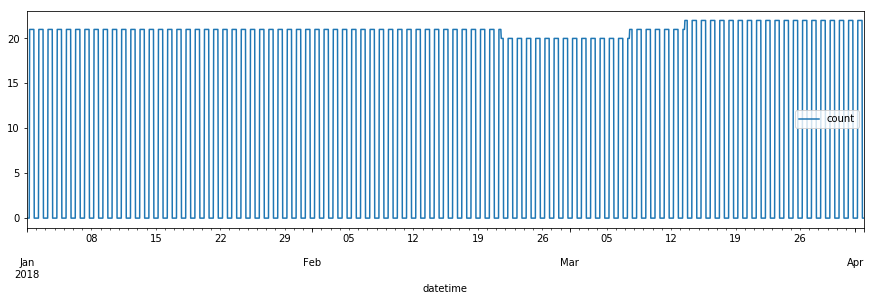

In [42]:
exampleTS['2018-01-01':'2018-04-01'].plot(figsize=(15,4))

## Helper Functions

In [8]:
def keepOnlyWorkingHours(startDate, endDate):
    
    local_df = pd.DataFrame()
    local_df['datetime'] = pd.date_range('2018-01-01 00:00:00', '2018-12-31 23:00:00', freq='1h')
    local_df.set_index('datetime', inplace=True)
    local_df['count'] = 0
    
    hour = datetime.timedelta(hours=1)

    while (startDate <= endDate):
        
        if(startDate.year > 2018):
            break
        else:
            if( (startDate.hour >= 7) and (startDate.hour <= 18) and (startDate.year == 2018)):
                local_df.loc[startDate]['count'] = 1
                
        startDate = startDate + hour
        
    return local_df


def spatialJoin(geoDataFrame, lat, lon):
    
    d = 300
    n_points = 20
    angles = np.linspace(0, 360, n_points)
    center = shapely.geometry.Point(lon, lat)
    polygon = Polygon(geog.propagate(center, angles, d))
    
    sinpoly = gpd.GeoDataFrame(crs={'init': 'epsg:4326'})
    sinpoly = sinpoly.append({'geometry': polygon}, ignore_index=True)
    sinpoly = sinpoly.to_crs({'init':'epsg:3857'})
    
    dataframe = gpd.tools.sjoin(geoDataFrame, sinpoly, how='inner', op='within')
    
    return dataframe

def latLngToPoint(lat, lng):
    
    return shapely.geometry.Point(lng, lat)

def formatBBL(block, lot):
    
    block = str(block)
    lot = str(lot)
    
    block_split = block.split('.')[0]
    lot_split = lot.split('.')[0]
    
    BBL = str(block_split) + str(lot_split)
    
    return BBL

def aggregationLargestInterval(series):
    print(series[0])
    return series[0]